In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math


In [9]:
print("TensorFlow version: {}".format(tf.VERSION))

TensorFlow version: 1.2.1


In [10]:
# Convolutional Layer 1.
#When dealing with high-dimensional inputs such as images, 
#it is impractical to connect neurons to all neurons in the previous layer. 
#Instead, we will connect each neuron to only a local region of the input layer. 
#The spatial extent of this connectivity is a hyperparameter called the receptive field 
#of the neuron (equivalently this is the filter size). 
#smaller size than input
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

#more filters
# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.


In [16]:
data = input_data.read_data_sets('data/MNIST/', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz


Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [21]:
print("Size of:")
print("- Training-set:\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


Size of:
- Training-set:	55000
- Test-set:		10000
- Validation-set:	5000


In [35]:
# one-hot labels
print("One-hot labels:\n ", data.test.labels)
# from one-hot to class numbers
data.test.cls = np.argmax(data.test.labels, axis=1)
print("\nClass labels:\n", data.test.cls)


One-hot labels:
  [[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Class labels:
 [7 2 1 ..., 4 5 6]


In [36]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
#https://en.wikipedia.org/wiki/Channel_(digital_image)
#channels mean number of primary colors
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [59]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.set_facecolor('white')

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

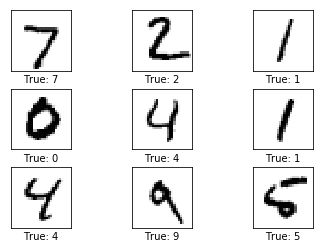

In [60]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [61]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


In [62]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


In [63]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
    
    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    
    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')    
    
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    
    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')    

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [64]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [66]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [68]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

# The convolutional layers expect x to be encoded as a 4-dim tensor
# so we have to reshape it so its shape is instead [num_images, img_height, img_width, num_channels]. 
# Note that img_height == img_width == img_size 
# and num_images can be inferred automatically by using -1 for the size of the first dimension. 
# So the reshape operation is:

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. 
# The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels 
# and each label is a vector of length num_classes which is 10 in this case.
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

# We could also have a placeholder variable for the class-number, 
# but we will instead calculate it using argmax. 
# Note that this is a TensorFlow operator so nothing is calculated at this point.
y_true_cls = tf.argmax(y_true, dimension=1)


In [69]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

# Check the shape of the tensor that will be output by the convolutional layer. 
# It is (?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?), 
# each image is 14 pixels wide and 14 pixels high, and there are 16 different channels, one channel for each of the filters.
# Note: image size is 14 after pooling
print(layer_conv1)

Tensor("Relu:0", shape=(?, 14, 14, 16), dtype=float32)


In [70]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=True)


# Check the shape of the tensor that will be output from this convolutional layer. 
# The shape is (?, 7, 7, 36) where the ? again means that there is an arbitrary number of images, 
# with each image having width and height of 7 pixels, and there are 36 channels, one for each filter.
print(layer_conv2)

Tensor("Relu_1:0", shape=(?, 7, 7, 36), dtype=float32)


In [72]:
# The convolutional layers output 4-dim tensors. 
# We now wish to use these as input in a fully-connected network, 
# which requires for the tensors to be reshaped or flattened to 2-dim tensors.

layer_flat, num_features = flatten_layer(layer_conv2)

# Check that the tensors now have shape (?, 1764) 
# which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. 
# Note that 1764 = 7 x 7 x 36.

print(layer_flat)
print("num_features: ",num_features)

Tensor("Reshape_2:0", shape=(?, 1764), dtype=float32)
num_features:  1764


In [73]:
# Add a fully-connected layer to the network. 
# The input is the flattened layer from the previous convolution. 
# The number of neurons or nodes in the fully-connected layer is fc_size. 
# ReLU is used so we can learn non-linear relations.
layer_fc = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True)

# Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and fc_size == 128.
print(layer_fc)

Tensor("Relu_2:0", shape=(?, 128), dtype=float32)


In [74]:
# Add another fully-connected layer that outputs vectors of length 10
# for determining which of the 10 classes the input image belongs to. 
# Note that ReLU is not used in this layer.
layer_fc2 = new_fc_layer(input=layer_fc,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

print(layer_fc2)


Tensor("add_3:0", shape=(?, 10), dtype=float32)


In [76]:
# The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. 
# However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, 
# so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. 
# This is calculated using the so-called softmax function and the result is stored in y_pred.

y_pred = tf.nn.softmax(layer_fc2)

y_pred_cls = tf.argmax(y_pred, dimension=1)


To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

In [79]:
# TensorFlow has a built-in function for calculating the cross-entropy. 
# Note that the function calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied.

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

# We have now calculated the cross-entropy for each of the image classifications,
# so we have a measure of how well the model performs on each image individually. 
# But in order to use the cross-entropy to guide the optimization of the model's variables,
# we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

cost = tf.reduce_mean(cross_entropy)


In [80]:
# Now that we have a cost measure that must be minimized, 
# we can then create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent.
# Note that optimization is not performed at this point. 
# In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


In [82]:
# We need a few more performance measures to display the progress to the user.
# This is a vector of booleans whether the predicted class equals the true class of each image.

correct_predictions = tf.equal(y_pred_cls, y_true_cls)

# This calculates the classification accuracy by first type-casting the vector of booleans to floats, 
# so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


In [83]:
# Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

session = tf.Session()


In [85]:
# The variables for weights and biases must be initialized before we start optimizing them.

session.run(tf.global_variables_initializer())


In [89]:
# There are 55,000 images in the training-set. 
# It takes a long time to calculate the gradient of the model using all these images. 
# We therefore only use a small batch of images in each iteration of the optimizer.
# If your computer crashes or becomes very slow because you run out of RAM, 
# then you may try and lower this number, but you may then need to perform more optimization iterations.

train_batch_size = 64

# Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. 
# In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. 
# The progress is printed every 100 iterations.

# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [90]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [106]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.gcf().set_facecolor('white')
    plt.show()

In [93]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [94]:
# The accuracy on the test-set is very low,
# because the model variables have only been initialized and not optimized at all, 
# so it just classifies the images randomly.

print_test_accuracy()

Accuracy on Test-Set: 10.7% (1072 / 10000)


In [95]:
# The classification accuracy does not improve much from just 1 optimization iteration, 
# because the learning-rate for the optimizer is set very low.

optimize(num_iterations=1)


Optimization Iteration:      1, Training Accuracy:  12.5%
Time usage: 0:00:00


In [96]:
print_test_accuracy()

Accuracy on Test-Set: 11.4% (1138 / 10000)


In [97]:
optimize(num_iterations=99)  # we already performed 1 iteration above.


Time usage: 0:00:05


In [98]:
print_test_accuracy()

Accuracy on Test-Set: 65.0% (6498 / 10000)


Accuracy on Test-Set: 65.0% (6498 / 10000)
Example errors:


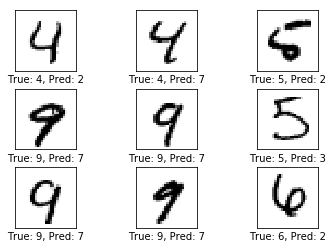

In [99]:
print_test_accuracy(show_example_errors=True)

In [100]:
optimize(num_iterations=900) # we performed 100 iterations above

Optimization Iteration:    101, Training Accuracy:  70.3%


Optimization Iteration:    201, Training Accuracy:  87.5%


Optimization Iteration:    301, Training Accuracy:  81.2%


Optimization Iteration:    401, Training Accuracy:  93.8%


Optimization Iteration:    501, Training Accuracy:  90.6%


Optimization Iteration:    601, Training Accuracy:  85.9%


Optimization Iteration:    701, Training Accuracy:  89.1%


Optimization Iteration:    801, Training Accuracy:  95.3%


Optimization Iteration:    901, Training Accuracy:  89.1%


Time usage: 0:00:44


Accuracy on Test-Set: 93.1% (9311 / 10000)
Example errors:


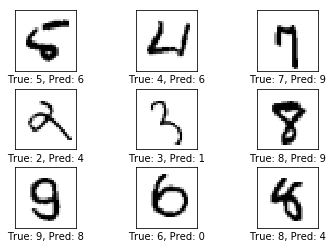

In [101]:
print_test_accuracy(show_example_errors=True)


In [102]:
optimize(num_iterations=9000) # we performed 1000 iterations above

Optimization Iteration:   1001, Training Accuracy:  95.3%


Optimization Iteration:   1101, Training Accuracy:  92.2%


Optimization Iteration:   1201, Training Accuracy:  95.3%


Optimization Iteration:   1301, Training Accuracy:  84.4%


Optimization Iteration:   1401, Training Accuracy:  92.2%


Optimization Iteration:   1501, Training Accuracy:  96.9%


Optimization Iteration:   1601, Training Accuracy:  98.4%


Optimization Iteration:   1701, Training Accuracy:  93.8%


Optimization Iteration:   1801, Training Accuracy:  95.3%


Optimization Iteration:   1901, Training Accuracy:  98.4%


Optimization Iteration:   2001, Training Accuracy:  92.2%


Optimization Iteration:   2101, Training Accuracy:  96.9%


Optimization Iteration:   2201, Training Accuracy:  98.4%


Optimization Iteration:   2301, Training Accuracy:  98.4%


Optimization Iteration:   2401, Training Accuracy:  96.9%


Optimization Iteration:   2501, Training Accuracy:  96.9%


Optimization Iteration:   2601, Training Accuracy:  98.4%


Optimization Iteration:   2701, Training Accuracy:  98.4%


Optimization Iteration:   2801, Training Accuracy:  92.2%


Optimization Iteration:   2901, Training Accuracy:  95.3%


Optimization Iteration:   3001, Training Accuracy:  96.9%


Optimization Iteration:   3101, Training Accuracy: 100.0%


Optimization Iteration:   3201, Training Accuracy:  98.4%


Optimization Iteration:   3301, Training Accuracy:  95.3%


Optimization Iteration:   3401, Training Accuracy: 100.0%


Optimization Iteration:   3501, Training Accuracy:  96.9%


Optimization Iteration:   3601, Training Accuracy:  96.9%


Optimization Iteration:   3701, Training Accuracy:  98.4%


Optimization Iteration:   3801, Training Accuracy:  92.2%


Optimization Iteration:   3901, Training Accuracy:  95.3%


Optimization Iteration:   4001, Training Accuracy: 100.0%


Optimization Iteration:   4101, Training Accuracy:  96.9%


Optimization Iteration:   4201, Training Accuracy: 100.0%


Optimization Iteration:   4301, Training Accuracy: 100.0%


Optimization Iteration:   4401, Training Accuracy:  98.4%


Optimization Iteration:   4501, Training Accuracy:  98.4%


Optimization Iteration:   4601, Training Accuracy:  95.3%


Optimization Iteration:   4701, Training Accuracy:  96.9%


Optimization Iteration:   4801, Training Accuracy: 100.0%


Optimization Iteration:   4901, Training Accuracy:  98.4%


Optimization Iteration:   5001, Training Accuracy:  98.4%


Optimization Iteration:   5101, Training Accuracy:  96.9%


Optimization Iteration:   5201, Training Accuracy:  96.9%


Optimization Iteration:   5301, Training Accuracy:  98.4%


Optimization Iteration:   5401, Training Accuracy:  98.4%


Optimization Iteration:   5501, Training Accuracy:  98.4%


Optimization Iteration:   5601, Training Accuracy: 100.0%


Optimization Iteration:   5701, Training Accuracy:  96.9%


Optimization Iteration:   5801, Training Accuracy: 100.0%


Optimization Iteration:   5901, Training Accuracy: 100.0%


Optimization Iteration:   6001, Training Accuracy: 100.0%


Optimization Iteration:   6101, Training Accuracy: 100.0%


Optimization Iteration:   6201, Training Accuracy:  98.4%


Optimization Iteration:   6301, Training Accuracy:  98.4%


Optimization Iteration:   6401, Training Accuracy:  98.4%


Optimization Iteration:   6501, Training Accuracy:  93.8%


Optimization Iteration:   6601, Training Accuracy:  98.4%


Optimization Iteration:   6701, Training Accuracy:  96.9%


Optimization Iteration:   6801, Training Accuracy:  96.9%


Optimization Iteration:   6901, Training Accuracy:  96.9%


Optimization Iteration:   7001, Training Accuracy: 100.0%


Optimization Iteration:   7101, Training Accuracy:  96.9%


Optimization Iteration:   7201, Training Accuracy: 100.0%


Optimization Iteration:   7301, Training Accuracy: 100.0%


Optimization Iteration:   7401, Training Accuracy:  96.9%


Optimization Iteration:   7501, Training Accuracy: 100.0%


Optimization Iteration:   7601, Training Accuracy: 100.0%


Optimization Iteration:   7701, Training Accuracy: 100.0%


Optimization Iteration:   7801, Training Accuracy:  98.4%


Optimization Iteration:   7901, Training Accuracy: 100.0%


Optimization Iteration:   8001, Training Accuracy:  98.4%


Optimization Iteration:   8101, Training Accuracy:  96.9%


Optimization Iteration:   8201, Training Accuracy:  98.4%


Optimization Iteration:   8301, Training Accuracy:  98.4%


Optimization Iteration:   8401, Training Accuracy: 100.0%


Optimization Iteration:   8501, Training Accuracy:  98.4%


Optimization Iteration:   8601, Training Accuracy:  98.4%


Optimization Iteration:   8701, Training Accuracy:  95.3%


Optimization Iteration:   8801, Training Accuracy: 100.0%


Optimization Iteration:   8901, Training Accuracy: 100.0%


Optimization Iteration:   9001, Training Accuracy: 100.0%


Optimization Iteration:   9101, Training Accuracy: 100.0%


Optimization Iteration:   9201, Training Accuracy: 100.0%


Optimization Iteration:   9301, Training Accuracy: 100.0%


Optimization Iteration:   9401, Training Accuracy: 100.0%


Optimization Iteration:   9501, Training Accuracy: 100.0%


Optimization Iteration:   9601, Training Accuracy:  98.4%


Optimization Iteration:   9701, Training Accuracy: 100.0%


Optimization Iteration:   9801, Training Accuracy:  95.3%


Optimization Iteration:   9901, Training Accuracy:  98.4%


Time usage: 0:07:37


Accuracy on Test-Set: 98.8% (9875 / 10000)
Example errors:


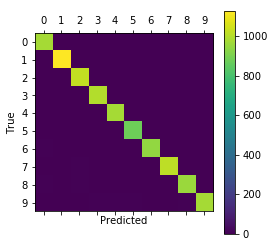

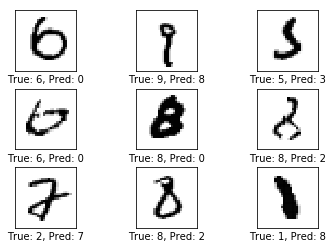

Confusion Matrix:
[[ 975    0    0    0    0    0    1    1    3    0]
 [   0 1128    4    0    0    0    1    1    1    0]
 [   1    0 1026    1    0    0    0    3    1    0]
 [   2    0    1  998    0    3    0    2    4    0]
 [   0    0    1    0  978    0    1    1    0    1]
 [   2    1    0    4    0  881    2    0    1    1]
 [   6    2    0    1    1    3  943    0    2    0]
 [   0    1    7    2    0    0    0 1015    2    1]
 [   5    0    5    1    1    0    1    2  957    2]
 [   4    4    0    5    6    6    1    4    5  974]]


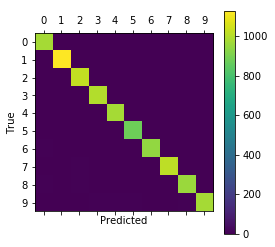

In [107]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)


In [108]:
# I'm trying to understand why the convolutional neural network can recognize handwritten digits, 
# we will now visualize the weights of the convolutional filters and the resulting output images.

In [109]:

def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [110]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [113]:
def plot_image(image):
    plt.gcf().set_facecolor('white')
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

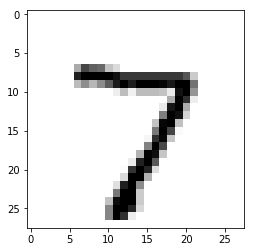

In [114]:

image1 = data.test.images[0]
plot_image(image1)

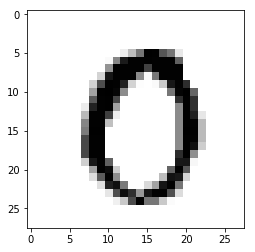

In [117]:

image2 = data.test.images[13]
plot_image(image2)

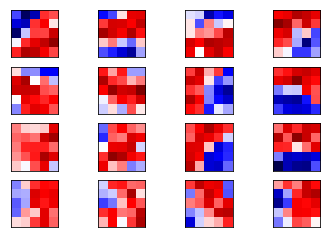

In [118]:
# Now plot the filter-weights for the first convolutional layer.
# Note that positive weights are red and negative weights are blue.

plot_conv_weights(weights=weights_conv1)

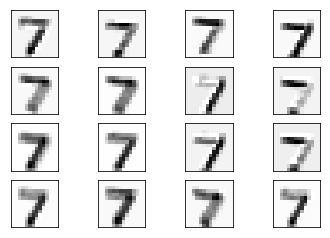

In [119]:
# Applying each of these convolutional filters to the first input image gives the following output images,
# which are then used as input to the second convolutional layer. 
# Note that these images are down-sampled to 14 x 14 pixels which is half the resolution of the original input image.

plot_conv_layer(layer=layer_conv1, image=image1)

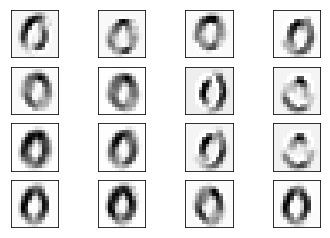

In [120]:
# The following images are the results of applying the convolutional filters to the second image.

plot_conv_layer(layer=layer_conv1, image=image2)

In [121]:
# It is difficult to see from these images what the purpose of the convolutional filters might be. 
# It appears that they have merely created several variations of the input image, 
# as if light was shining from different angles and casting shadows in the image.

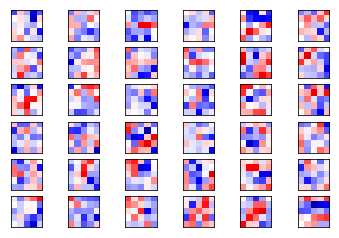

In [123]:
# Now plot the filter-weights for the second convolutional layer.
# There are 16 output channels from the first conv-layer, 
# which means there are 16 input channels to the second conv-layer. 
# The second conv-layer has a set of filter-weights for each of its input channels. 
# We start by plotting the filter-weigths for the first channel. 
# Note again that positive weights are red and negative weights are blue.

plot_conv_weights(weights=weights_conv2, input_channel=0)

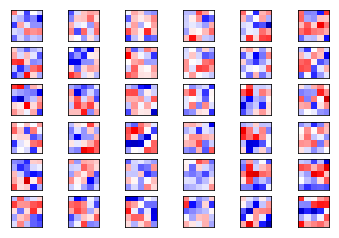

In [124]:
# There are 16 input channels to the second convolutional layer, 
# so we can make another 15 plots of filter-weights like this. 
# We just make one more with the filter-weights for the second channel.

plot_conv_weights(weights=weights_conv2, input_channel=1)

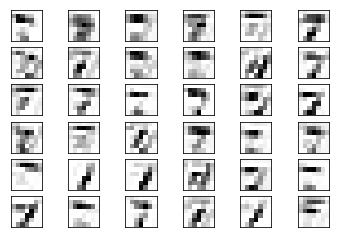

In [125]:
# It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.
# Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.
# Note that these are down-sampled yet again to 7 x 7 pixels which is half the resolution of the images from the first conv-layer.

plot_conv_layer(layer=layer_conv2, image=image1)

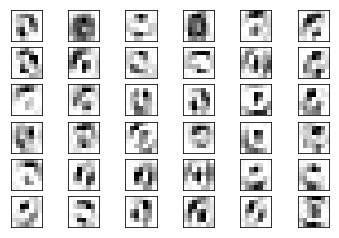

In [126]:
plot_conv_layer(layer=layer_conv2, image=image2)

In [127]:
# From these images, it looks like the second convolutional layer might detect lines and patterns in the input images, 
# which are less sensitive to local variations in the original input images. 
# These images are then flattened and input to the fully-connected layer, but that is not shown here.

In [129]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
session.close()